In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import sklearn


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, LSTM, Input,SpatialDropout1D, GlobalMaxPool1D, MaxPooling1D, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_score, accuracy_score, recall_score, f1_score
from tensorflow.keras.optimizers import Adam

In [5]:
# 5. Membaca file CSV ke dalam DataFrame
import pandas as pd
df = pd.read_csv('dataset_50k.csv')
df.head()

Unnamed: 0  Label                                         detokenize
0           0      1  aku luka diri aku jalan hidup sulit orang tua ...
1           1      0   buang pikir negatif laku gelisah milik putus asa
2           2      1  jujur aku takut mati aku orang aku sulit paham...
3           3      0              saya mes pasang sepatu jam saya harap
4           4      1  capek hati banget aku allah aku kayak mata ora...

In [7]:
df = df.dropna()
df

Unnamed: 0  Label                                         detokenize
0               0      1  aku luka diri aku jalan hidup sulit orang tua ...
1               1      0   buang pikir negatif laku gelisah milik putus asa
2               2      1  jujur aku takut mati aku orang aku sulit paham...
3               3      0              saya mes pasang sepatu jam saya harap
4               4      1  capek hati banget aku allah aku kayak mata ora...
...           ...    ...                                                ...
50518       50518      0  curi rampok liar begal rakyat senantiasa resah...
50519       50519      0                      saya bicara saya buat tertawa
50520       50520      1  sakit sakit guna sakit bahagia sakit bohong or...
50521       50521      1                              lantai lantai gelisah
50522       50522      1  aku tulis catat kemarin kata tunang aku laku b...

[50523 rows x 3 columns]

In [9]:
df['label'] = df['Label'].apply(lambda x: 0 if x == 0 else 1)
df.head()

Unnamed: 0  Label                                         detokenize  label
0           0      1  aku luka diri aku jalan hidup sulit orang tua ...      1
1           1      0   buang pikir negatif laku gelisah milik putus asa      0
2           2      1  jujur aku takut mati aku orang aku sulit paham...      1
3           3      0              saya mes pasang sepatu jam saya harap      0
4           4      1  capek hati banget aku allah aku kayak mata ora...      1

<BarContainer object of 2 artists>

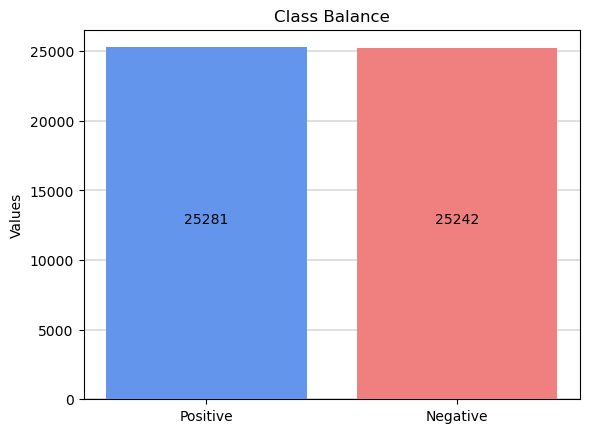

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center',zorder=4)

# Count the values in the 'Label' column
count = df['Label'].value_counts()
x = ["Positive", "Negative"]  # Custom labels for class balance plot
y = [count[1], count[0]]
addlabels(x,y)
plt.ylabel("Values")
plt.title('Class Balance')
plt.grid(color='dimgray', linewidth=0.3, axis='y',zorder=0)
plt.bar(x,y, color= ['cornflowerblue', 'lightcoral'], zorder=3)

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vektorisasi teks menggunakan TF-IDF unigram(1,1)
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,1), max_df=0.7, max_features=10000)

# Menggunakan fit_transform untuk mengubah dokumen menjadi fitur
vector = vectorizer.fit_transform(df['detokenize']).toarray()
tf_idf_len = len(vectorizer.vocabulary_)

In [17]:
#Split data 70% data train and 30% data test
x_unigram = pd.DataFrame(vector)
label = df["Label"]
x_train, x_test, y_train, y_test =  model_selection.train_test_split(x_unigram,label, test_size = 0.3)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(35366, 3445) (35366,)
(15157, 3445) (15157,)


In [19]:
y_train

21451    1
19760    1
20051    0
1128     0
28778    0
        ..
7207     1
33147    0
20813    0
42117    0
39333    0
Name: Label, Length: 35366, dtype: int64

In [21]:
x_train = np.array(x_train).reshape(-1, 1, x_train.shape[1])
x_test = np.array(x_test).reshape(-1, 1, x_test.shape[1])

In [23]:
x_train

array([[[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]]])

In [25]:
x_train.shape

(35366, 1, 3445)

In [27]:
import matplotlib.pyplot as plt

def make_plot(history, train, validation, title):
    graph = plt.plot(history.history[train], lw=2.0)
    graph = plt.plot(history.history[validation], lw=2.0)
    graph = plt.title(title)
    graph = plt.legend(['training', 'validasi'])
    graph = plt.show()

    return graph

In [29]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Membuat model hybrid lstm-cnn
def hybrid_lstm_cnn(x_train, y_train, x_test, y_test):


    model = Sequential()
    model.add(Input(shape=(1,x_train.shape[2])))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',optimizer=optimizer ,metrics=['accuracy'])
    print(model.summary())

    history = model.fit(x_train, y_train, epochs = 10, validation_data=(x_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)] )

    #Membuat plot garis akurasi
    make_plot(history, "accuracy", "val_accuracy", "Perubahan Akurasi tiap epoch")

    #predict
    predictions = model.predict(x_test)
    print()
    print("Classification Report :")
    print(classification_report(y_test, predictions.round(), digits=6))


    acc_score = accuracy_score(y_test, predictions.round())
    prec_score = precision_score(y_test, predictions.round())
    rec_score = recall_score(y_test, predictions.round())
    f1score = f1_score(y_test, predictions.round())

    return [acc_score,prec_score,rec_score,f1score ]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ spatial_dropout1d               │ (None, 1, 3445)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1, 128)         │     1,829,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1, 128)         │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,916,097 (7.31 MB)

 Trainable params: 1,916,097 (7.31 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.7410 - loss: 0.5011 - val_accuracy: 0.8125 - val_loss: 0.3799
Epoch 2/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - accuracy: 0.8174 - loss: 0.3719 - val_accuracy: 0.8203 - val_loss: 0.3668
Epoch 3/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.8276 - loss: 0.3560 - val_accuracy: 0.8234 - val_loss: 0.3641
Epoch 4/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.8338 - loss: 0.3455 - val_accuracy: 0.8259 - val_loss: 0.3615
Epoch 5/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.8361 - loss: 0.3358 - val_accuracy: 0.8239 - val_loss: 0.3645
Epoch 6/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.8419 - loss: 0.3297 - val_accuracy: 0.8233 - val_loss: 0.3684
Epoch 7/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.8408 - loss: 0.3247 - val_accuracy: 0.8219 - val_loss: 0.3734


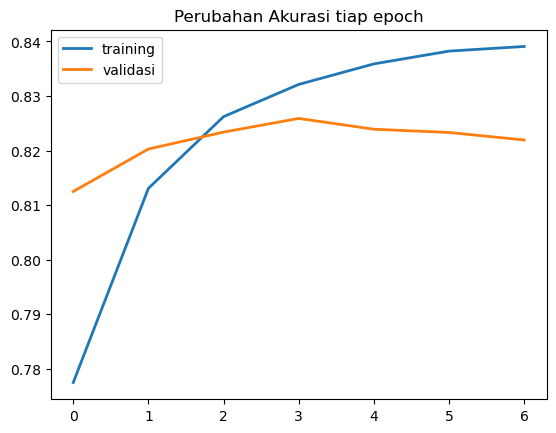

474/474 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.849059  0.786220  0.816432      7634
           1   0.798220  0.858168  0.827109      7523

    accuracy                       0.821930     15157
   macro avg   0.823639  0.822194  0.821771     15157
weighted avg   0.823826  0.821930  0.821731     15157



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ spatial_dropout1d_1             │ (None, 1, 3445)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 128)         │     1,829,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 128)         │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,916,097 (7.31 MB)

 Trainable params: 1,916,097 (7.31 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - accuracy: 0.7229 - loss: 0.5079 - val_accuracy: 0.8140 - val_loss: 0.3715
Epoch 2/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - accuracy: 0.8182 - loss: 0.3712 - val_accuracy: 0.8191 - val_loss: 0.3639
Epoch 3/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 34s 30ms/step - accuracy: 0.8256 - loss: 0.3569 - val_accuracy: 0.8223 - val_loss: 0.3649
Epoch 4/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - accuracy: 0.8333 - loss: 0.3456 - val_accuracy: 0.8234 - val_loss: 0.3617
Epoch 5/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - accuracy: 0.8391 - loss: 0.3314 - val_accuracy: 0.8232 - val_loss: 0.3658
Epoch 6/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - accuracy: 0.8427 - loss: 0.3288 - val_accuracy: 0.8213 - val_loss: 0.3639
Epoch 7/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 33s 29ms/step - accuracy: 0.8430 - loss: 0.3268 - val_accuracy: 0.8251 - val_loss: 0.3692


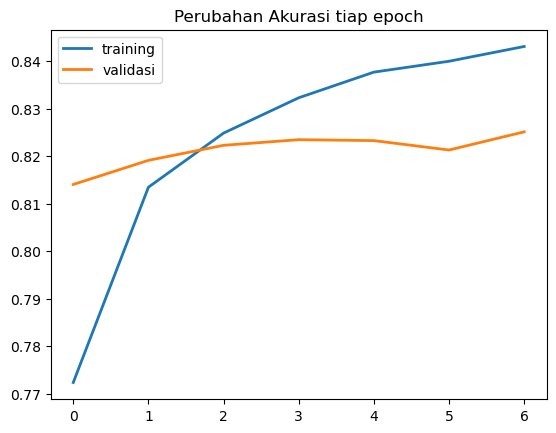

474/474 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.840695  0.805345  0.822640      7634
           1   0.810556  0.845142  0.827487      7523

    accuracy                       0.825097     15157
   macro avg   0.825625  0.825243  0.825064     15157
weighted avg   0.825736  0.825097  0.825046     15157



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ spatial_dropout1d_2             │ (None, 1, 3445)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 128)         │     1,829,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1, 128)         │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,916,097 (7.31 MB)

 Trainable params: 1,916,097 (7.31 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.7398 - loss: 0.5008 - val_accuracy: 0.8182 - val_loss: 0.3707
Epoch 2/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - accuracy: 0.8187 - loss: 0.3708 - val_accuracy: 0.8232 - val_loss: 0.3655
Epoch 3/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 35s 32ms/step - accuracy: 0.8303 - loss: 0.3527 - val_accuracy: 0.8227 - val_loss: 0.3627
Epoch 4/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 36s 32ms/step - accuracy: 0.8315 - loss: 0.3454 - val_accuracy: 0.8236 - val_loss: 0.3629
Epoch 5/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 37s 33ms/step - accuracy: 0.8404 - loss: 0.3290 - val_accuracy: 0.8203 - val_loss: 0.3634
Epoch 6/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 36s 32ms/step - accuracy: 0.8466 - loss: 0.3244 - val_accuracy: 0.8235 - val_loss: 0.3685


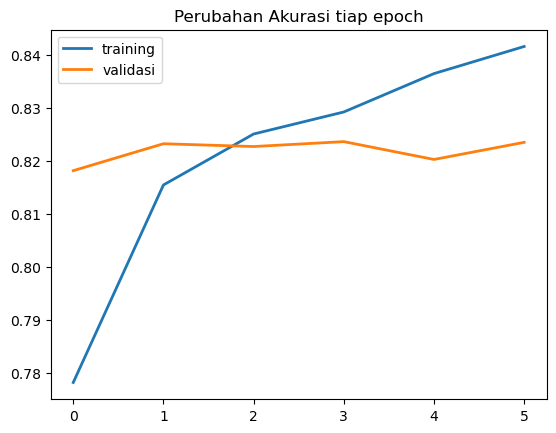

474/474 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.840077  0.802332  0.820771      7634
           1   0.808162  0.845009  0.826175      7523

    accuracy                       0.823514     15157
   macro avg   0.824119  0.823670  0.823473     15157
weighted avg   0.824236  0.823514  0.823453     15157



In [31]:
result = []
result.append(hybrid_lstm_cnn(x_train, y_train, x_test, y_test))
result.append(hybrid_lstm_cnn(x_train, y_train, x_test, y_test))
result.append(hybrid_lstm_cnn(x_train, y_train, x_test, y_test))

In [33]:
average = np.mean(result, axis=0, dtype=float)
print('Average Accuracy  :', average[0])
print('Average Precision :', average[1])
print('Average Recall    :', average[2])
print('Average F1-Score  :', average[3])

Average Accuracy  : 0.8235138879725539
Average Precision : 0.8056457106822776
Average Recall    : 0.8494394966547034
Average F1-Score  : 0.8269237010524009
